Topic: Parking Lock Battery Life Prediction

Member: Feng Huang(001230993), Meng Tan(001856443), Zhaojie Liu(001210764)

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import pymc3 as pm, theano.tensor as tt
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Connect to MySql DataBase

In [2]:
mydb = mysql.connector.connect(
    host="192.168.1.151",
    user="root",
    passwd="12345678",
    database="dingding"
)

df = pd.read_sql("select count(*) from t_lock_report_record", con=mydb)
df

,count(*)
0,1638369


In [3]:
df = pd.read_sql("select * from t_lock_report_record where BatteryVolume > 0", con=mydb)
df.tail()

,ReportId,LockId,UserId,Operation,Method,State,OperTime,BatteryVolume,OperType,ReportTime,SignalStrength,MobileBattery,NetworkType,AreaId,AppVersion,OSVersion,FailedReason,Longitude,Latitude
1088787,1640066,DNF87928896BAE,18668222668M,D,0,3,2018-12-14 02:28:55,4.07,0,2018-12-14 02:28:54,-90.0,55,M,2734,3.2.4,Android:8.1.0,success,120.285621,30.209695
1088788,1640091,DNFC08BC6E55A7,18907167678M,D,0,3,2018-12-14 03:59:34,7.16,0,2018-12-14 03:59:35,-96.0,4,M4,3492,3.2.4,Android:8.0.0,success,114.352376,30.566901
1088789,1640095,DNFC08BC6E55A7,18907167678M,U,0,3,2018-12-14 04:00:25,7.16,0,2018-12-14 04:00:25,-96.0,4,M4,3492,3.2.4,Android:8.0.0,success,114.352376,30.566901
1088790,1640100,DNFC08BC6E55A7,18567685535M,D,0,3,2018-12-14 04:01:58,7.16,0,2018-12-14 04:01:59,-82.0,100,M4,3492,3.2.4,Android:8.0.0,success,114.353268,30.566199
1088791,1640101,DNE74FB9BE5AA0,15014128520M,D,0,3,2018-12-14 04:19:00,0.02,0,2018-12-14 04:19:07,-95.0,51,M4,2497,3.2.3,iOS:11.4.1,success,113.849992,22.778541


Create a new table with just the columns we need:

DROP TABLE IF EXISTS t_lock_battery_record;

CREATE TABLE t_lock_battery_record (

	SELECT
		ReportId,
        LEFT(LockId,2) AS LockPrefix,
		LockId,
		OperTime,
		BatteryVolume 
	FROM
		t_lock_report_record 
	WHERE
		Operation = 'D' 
		AND ( FailedReason IS NULL OR FailedReason = '' OR FailedReason = 'success' OR FailedReason = 'operFinish' ) 
		AND BatteryVolume > 0 
	);

In [4]:
df = pd.read_sql("select * from t_lock_battery_record", con=mydb)
df.tail()

,ReportId,LockPrefix,LockId,OperTime,BatteryVolume
563393,1640065,DK,DKE0124B5BC192,2018-12-14 02:20:34,3.73
563394,1640066,DN,DNF87928896BAE,2018-12-14 02:28:55,4.07
563395,1640091,DN,DNFC08BC6E55A7,2018-12-14 03:59:34,7.16
563396,1640100,DN,DNFC08BC6E55A7,2018-12-14 04:01:58,7.16
563397,1640101,DN,DNE74FB9BE5AA0,2018-12-14 04:19:00,0.02


Focus on locks of DW and DQ type

These two types of parking lock use dry battery and hava more complete data than other types. Delete data with too low or too high voltage.

In [5]:
DW = pd.read_sql("select * from t_lock_battery_record where LockPrefix='DW' or LockPrefix='DQ'", con=mydb)
DW = DW[(DW.BatteryVolume>0.5)&(DW.BatteryVolume<1.17)]
DW['Date'] = DW.OperTime.values.astype('datetime64[D]')
DW.tail()

,ReportId,LockPrefix,LockId,OperTime,BatteryVolume,Date
292391,1639967,DW,DWEC24B825457E,2018-12-13 22:32:44,0.89,2018-12-13
292392,1640007,DW,DWD4F513604FAF,2018-12-13 23:43:50,0.99,2018-12-13
292393,1640036,DW,DWEC24B825995D,2018-12-14 00:33:53,0.91,2018-12-14
292394,1640037,DW,DWEC24B825995D,2018-12-14 00:34:00,0.91,2018-12-14
292395,1640055,DW,DWEC24B816EE72,2018-12-14 01:17:55,0.75,2018-12-14


The distribution of battery voltage:

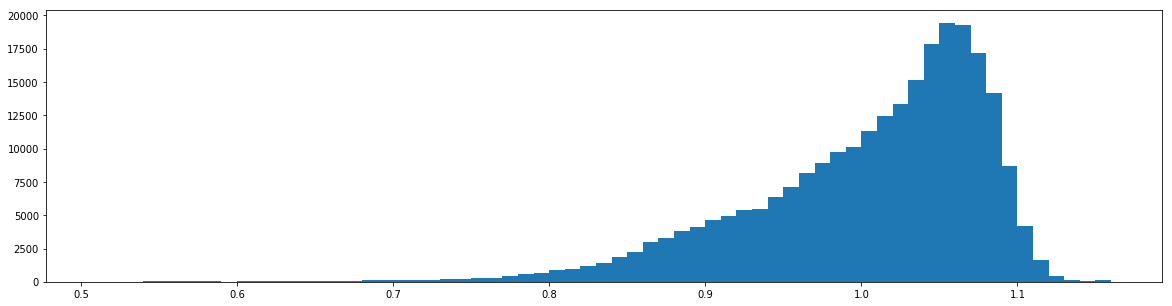

In [6]:
plt.figure(figsize=(20,5)) 
plt.hist(DW.BatteryVolume,bins=65);

One good battery curve:

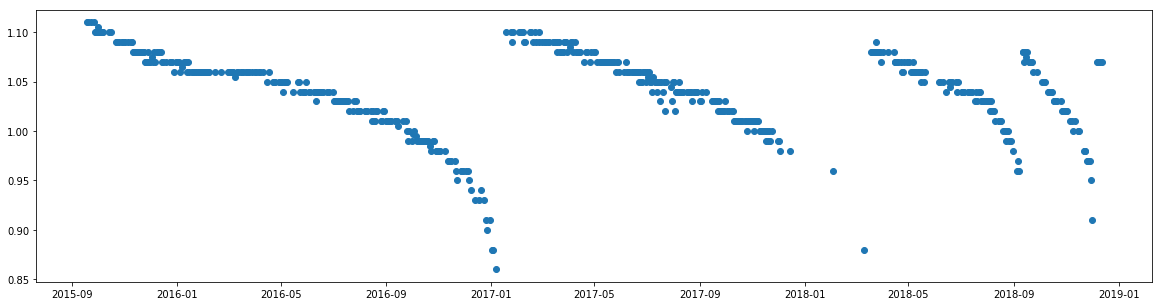

In [7]:
lock = DW[DW.LockId=='DQ7CEC79460B4C'].groupby(['Date']).mean().reset_index()
plt.figure(figsize=(20,5)) 
plt.plot_date(lock.Date, lock.BatteryVolume)

One bad battery curve:

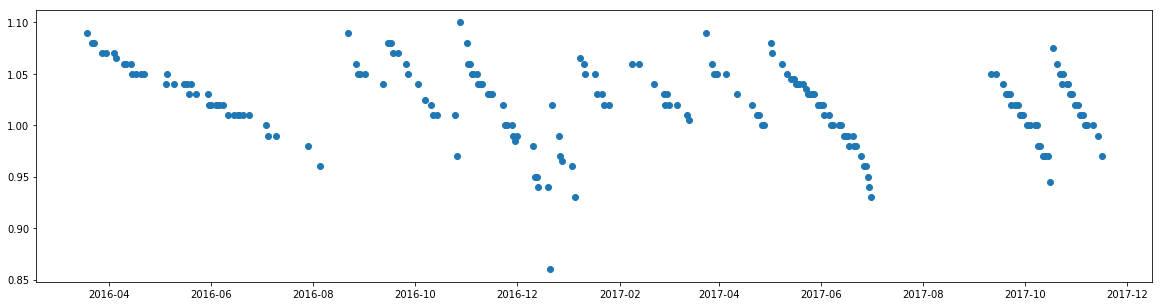

In [8]:
lock = DW[DW.LockId=='DWD4F513604F8C'].groupby(['Date']).mean().reset_index()
plt.figure(figsize=(20,5)) 
plt.plot_date(lock.Date, lock.BatteryVolume)

There are total 2094 locks

In [9]:
LockIds = DW.groupby('LockId').mean().reset_index()
LockIds.tail()

,LockId,ReportId,BatteryVolume
2089,DWEC24B8259AC3,9.984508e+05,1.033375
2090,DWEC24B8259AC5,9.096333e+05,1.043333
2091,DWEC24B8259AC6,7.323070e+05,1.010000
2092,DWEC24B8259ACA,1.370511e+06,1.000119
2093,DWEC24B8259ACD,1.146683e+06,0.941638


Find out when the battery is replaced and cut the batery curve into several complete battery cycles:

In [10]:
 def battery(LockId):
    lock = DW[DW.LockId==LockId]
    # Group by Date to decrease the number of data and the influence of some extreme value
    lock = lock.groupby(['Date']).mean()
    lock = lock.reset_index()
    Cycle = np.zeros(lock.shape[0])
    c = 0
    for i in range(lock.shape[0]-1):
        Cycle[i]=c
        # Determine when the battery is replaced
        if(lock.BatteryVolume[i+1]>0.9 and (lock.BatteryVolume[i+1]-lock.BatteryVolume[i])>0.1):
                c+=1
    Cycle[lock.shape[0]-1] = c
    lock['Cycle'] = pd.Series(Cycle)
    start = np.zeros(c)
    end = np.zeros(c)
    maxV = np.zeros(c)
    points = np.zeros(c)
    count = 0
    # Delete the last cycle
    for i in range(c):
        count+=lock[Cycle==i].shape[0]
        points[i] = lock[Cycle==i].shape[0]
        start[i] = lock[Cycle==i].Date.values.astype(float).min()
        end[i] = lock[Cycle==i].Date.values.astype(float).max()
        maxV[i] = lock[Cycle==i].BatteryVolume.max()
    cycle = np.zeros(count)
    use = np.zeros(count)
    remain = np.zeros(count)
    duration = np.zeros(count)
    voltage = np.zeros(count)
    decline = np.zeros(count)
    for i in range(count):
        last = (end[int(lock.Cycle[i])]-start[int(lock.Cycle[i])])/(24*3600*1000*1000*1000)
        # Delete cycle which last less than 30 days(too short for a complete cycle) 
        if (last < 30):
            cycle[i] = 0;
        else:
            cycle[i] = lock.Cycle[i]+1
        use[i] = (lock.Date.values.astype(float)[i]-start[int(lock.Cycle[i])])/(24*3600*1000*1000*1000)
        remain[i] = (end[int(lock.Cycle[i])]-lock.Date.values.astype(float)[i])/(24*3600*1000*1000*1000)
        duration[i] = last
        voltage[i] = lock.BatteryVolume[i]
        decline[i] = maxV[int(lock.Cycle[i])]-lock.BatteryVolume[i]
    curve = pd.DataFrame(cycle)
    curve.columns = ['cycle']
    curve['lockid'] = LockId
    curve['use'] = pd.Series(use)
    curve['voltage'] = pd.Series(voltage)
    curve['decline'] = pd.Series(decline)
    curve['remain'] = pd.Series(remain)
    curve['duration'] = pd.Series(duration)
    return curve[cycle > 0]

Original Data:

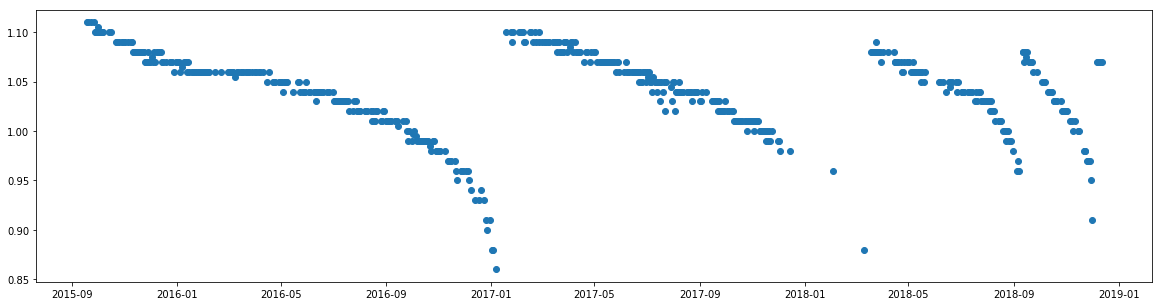

In [11]:
lock = DW[DW.LockId=='DQ7CEC79460B4C'].groupby(['Date']).mean().reset_index()
plt.figure(figsize=(20,5)) 
plt.plot_date(lock.Date, lock.BatteryVolume)

Batery Cycle Data:

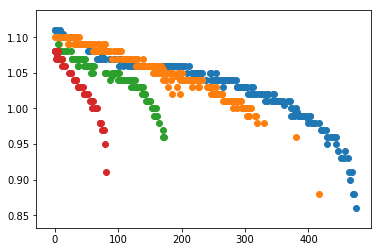

In [12]:
curve = battery('DQ7CEC79460B4C')
plt.scatter(curve[curve.cycle==1].use, curve[curve.cycle==1].voltage)
plt.scatter(curve[curve.cycle==2].use, curve[curve.cycle==2].voltage)
plt.scatter(curve[curve.cycle==3].use, curve[curve.cycle==3].voltage)
plt.scatter(curve[curve.cycle==4].use, curve[curve.cycle==4].voltage)

Deal with all the locks:

In [13]:
curves = battery('DWD4F513604E44')
for x in LockIds.LockId.values:
    if(x!='DWD4F513604E44'):
        curves = pd.concat([curves,battery(x)])
curves.tail()

,cycle,lockid,use,voltage,decline,remain,duration
392,2.0,DWEC24B8259ACD,170.0,0.970,0.110,4.0,174.0
393,2.0,DWEC24B8259ACD,171.0,0.970,0.110,3.0,174.0
394,2.0,DWEC24B8259ACD,172.0,0.960,0.120,2.0,174.0
395,2.0,DWEC24B8259ACD,173.0,0.970,0.110,1.0,174.0
396,2.0,DWEC24B8259ACD,174.0,0.965,0.115,0.0,174.0


Valid locks:

In [14]:
ids = curves.groupby('lockid').mean().reset_index()
ids['idNo'] = ids.index
ids.tail()

,lockid,cycle,use,voltage,decline,remain,duration,idNo
433,DWEC24B8259A99,1.000000,44.333333,1.016111,0.063889,80.666667,125.000000,433
434,DWEC24B8259AA6,1.000000,66.080000,0.988000,0.102000,65.920000,132.000000,434
435,DWEC24B8259AAB,1.000000,42.295775,0.913969,0.116031,41.704225,84.000000,435
436,DWEC24B8259ABF,1.208481,201.219081,0.958517,0.124805,237.021201,438.240283,436
437,DWEC24B8259ACD,1.342569,213.027708,0.930340,0.116788,190.415617,403.443325,437


In [15]:
curves = pd.merge(curves, ids[['idNo','lockid']], left_on='lockid', right_on='lockid')
curves.head()

,cycle,lockid,use,voltage,decline,remain,duration,idNo
0,1.0,DWD4F513604E44,0.0,1.080,0.005,338.0,338.0,158
1,1.0,DWD4F513604E44,1.0,1.080,0.005,337.0,338.0,158
2,1.0,DWD4F513604E44,2.0,1.085,0.000,336.0,338.0,158
3,1.0,DWD4F513604E44,7.0,1.080,0.005,331.0,338.0,158
4,1.0,DWD4F513604E44,8.0,1.080,0.005,330.0,338.0,158


Curve fit:

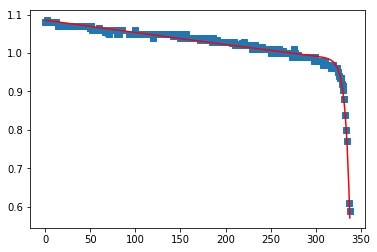

In [16]:
curve = battery('DWD4F513604E44')
x1 = curve.use.values
y1 = curve.voltage.values


def func(x, a, b, c, d):
    return a*np.exp(b*x)+c*np.exp(d*x)

popt, pcov = curve_fit(func, x1, y1,[0,0.1,1,0],maxfev=500000)
a = popt[0] 
b = popt[1]
c = popt[2] 
d = popt[3]
yvals = func(x1,a,b,c,d)

plot1 = plt.plot(curve.use.values, curve.voltage.values, 's',label='original values')
plot2 = plt.plot(x1, yvals, 'r',label='polyfit values')

It is overfitting. We can never predict when the battery will die with this curve fit.

So we build a new  model. Instead of getting voltage=f(day), we get day=f(voltage). Use a normalized voltage to get the normalized day, which also means Battery Percentage with a three degree fit function. The percentage and the use days will be linear. So we can use linear regression and predict the battery will die when the percentage is 0.

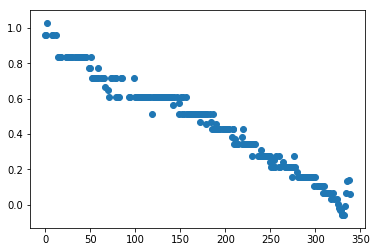

In [17]:
curve = battery('DWD4F513604E44')
p = np.zeros(curve.shape[0])
for i in range(curve.shape[0]):
    v = (0.16-curve.decline[i]) / 0.16
    p[i] = 0.2453*v**3 + 0.6316*v**2 + 0.1973*v - 0.0449
plt.scatter(curve.use, p)

statistics result of each lock and each cycle:

In [18]:
statistics = curves.groupby(['lockid','cycle']).max()
statistics

use   voltage   decline  remain  duration  idNo
lockid         cycle                                                   
DQ7CEC794602C7 1.0    412.0  1.080000  0.130000   412.0     412.0     0
DQ7CEC794602EB 1.0    328.0  1.100000  0.130000   328.0     328.0     1
               2.0    366.0  1.070000  0.370000   366.0     366.0     1
DQ7CEC794606D5 1.0     33.0  1.090000  0.110000    33.0      33.0     2
               2.0     83.0  1.110000  0.160000    83.0      83.0     2
               3.0     43.0  1.090000  0.205000    43.0      43.0     2
               4.0     52.0  1.105000  0.235000    52.0      52.0     2
DQ7CEC79460B19 1.0    562.0  1.100000  0.350000   562.0     562.0     3
               2.0    201.0  1.100000  0.260000   201.0     201.0     3
               3.0    256.0  1.040000  0.307500   256.0     256.0     3
               4.0     51.0  1.010000  0.250000    51.0      51.0     3
DQ7CEC79460B42 1.0     46.0  1.110000  0.210000    46.0      46.0     4
               2.0     51.0  1.110000  0.170000    51.0      51.0     4
DQ7CEC79460B4C 1.0    475.0  1.110000  0.250000   475.0     475.0     5
               2.0    416.0  1.100000  0.220000   416.0     416.0     5
               3.0    172.0  1.090000  0.130000   172.0     172.0     5
               4.0     81.0  1.080000  0.170000    81.0      81.0     5
DQC4BE8408BDF5 1.0    381.0  1.110000  0.150000   381.0     381.0     6
               2.0     59.0  1.080000  0.310000    59.0      59.0     6
               4.0     56.0  1.080000  0.140000    56.0      56.0     6
               5.0     50.0  1.070000  0.140000    50.0      50.0     6
DQC4BE8408C0EF 1.0    491.0  1.090000  0.200000   491.0     491.0     7
               2.0    175.0  1.090000  0.170000   175.0     175.0     7
               3.0    272.0  1.100000  0.130000   272.0     272.0     7
               4.0    216.0  1.090000  0.150000   216.0     216.0     7
DQC4BE8408C0F3 1.0    365.0  1.110000  0.250000   365.0     365.0     8
               2.0    509.0  1.110000  0.160000   509.0     509.0     8
DQC4BE8408C393 1.0    225.0  1.010000  0.080000   225.0     225.0     9
DQC4BE8408C3C1 1.0    510.0  1.100000  0.375000   510.0     510.0    10
DQC4BE8408C3CD 1.0    139.0  1.060000  0.060000   139.0     139.0    11
...                     ...       ...       ...     ...       ...   ...
DWEC24B8259909 1.0    225.0  1.050000  0.330000   225.0     225.0   421
               2.0    305.0  1.060000  0.490000   305.0     305.0   421
               3.0    112.0  0.972000  0.412000   112.0     112.0   421
               4.0    122.0  1.060000  0.250000   122.0     122.0   421
               5.0     88.0  1.090000  0.290000    88.0      88.0   421
DWEC24B825990A 1.0     72.0  1.033333  0.158333    72.0      72.0   422
               2.0    109.0  1.056667  0.346667   109.0     109.0   422
DWEC24B825990B 1.0    446.0  1.070000  0.240000   446.0     446.0   423
DWEC24B825991C 1.0     76.0  0.993333  0.375556    76.0      76.0   424
               2.0     77.0  1.016667  0.186667    77.0      77.0   424
               3.0     45.0  1.060000  0.400000    45.0      45.0   424
               5.0     77.0  1.010000  0.290000    77.0      77.0   424
DWEC24B825994E 1.0    680.0  1.050000  0.310000   680.0     680.0   425
DWEC24B8259952 1.0    594.0  1.020000  0.400000   594.0     594.0   426
DWEC24B8259958 1.0    277.0  1.055000  0.365000   277.0     277.0   427
               2.0    466.0  1.090000  0.480000   466.0     466.0   427
DWEC24B8259965 1.0    410.0  1.061667  0.381667   410.0     410.0   428
DWEC24B825996A 1.0    770.0  1.090000  0.320000   770.0     770.0   429
               2.0     30.0  1.035000  0.260000    30.0      30.0   429
DWEC24B825997A 1.0    205.0  1.050000  0.270000   205.0     205.0   430
DWEC24B8259A83 1.0     85.0  0.990000  0.170000    85.0      85.0   431
DWEC24B8259A8A 1.0    272.0  1.060000  0.230000   272.0     272.0   432
               2.0    294.0  1.010000  0.150000   294.0     294.

In [19]:
statistics.mean()

use         252.300000
voltage       1.064157
decline       0.230012
remain      252.300000
duration    252.300000
idNo        224.046053
dtype: float64

Bayesian Model:

In [20]:
use = curves.use.values
decline = curves.decline.values
duration = curves.duration.values
idNo = curves.idNo.values

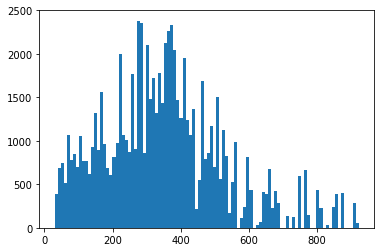

In [21]:
plt.hist(duration,bins=100);

In [22]:
with pm.Model() as model:

    g = pm.Normal("g", mu=0.2, sd=0.05, shape=450)
    a = pm.Normal("a", mu=0.25, sd=0.05, shape=450)
    b = pm.Normal("b", mu=0.6, sd=0.05, shape=450)
    c = pm.Normal("c", mu=0.2, sd=0.05, shape=450)
    d = pm.Normal("d", mu=-0.05, sd=0.05, shape=450)

    normalV = (g[idNo]-decline)/g[idNo]
    percent = a[idNo]*normalV**3+b[idNo]*normalV**2+c[idNo]*normalV+d[idNo]
    result = pm.Deterministic('result', use/(1-percent))
    
    observed = pm.Normal('observed', mu=result, sd=30, observed=duration)

In [23]:
with model:
    trace = pm.sample(100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, c, b, a, g]
Sampling 4 chains: 100%|██████████| 800/800 [00:22<00:00, 35.01draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9801363199090473, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9525252525252524, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9240981240981241, but should be close to 0.8. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `ta

Get the best coefficients for each lock

In [24]:
df_g = pd.DataFrame(pm.stats.quantiles(trace['g'])[50],columns=['g'])
df_a = pd.DataFrame(pm.stats.quantiles(trace['a'])[50],columns=['a'])
df_b = pd.DataFrame(pm.stats.quantiles(trace['b'])[50],columns=['b'])
df_c = pd.DataFrame(pm.stats.quantiles(trace['c'])[50],columns=['c'])
df_d = pd.DataFrame(pm.stats.quantiles(trace['d'])[50],columns=['d'])
df = pd.concat([df_g,df_a,df_b,df_c,df_d],axis=1)
df['idNo'] = df.index
df = pd.merge(df,ids[['idNo','lockid']],left_on='idNo',right_on='idNo')
df.tail()

,g,a,b,c,d,idNo,lockid
433,0.307982,0.933808,1.325246,0.237568,-0.424960,433,DWEC24B8259A99
434,0.384172,-0.215954,0.306864,0.528128,0.026012,434,DWEC24B8259AA6
435,-0.091209,1.012627,0.871071,0.566680,0.315588,435,DWEC24B8259AAB
436,0.361190,0.732594,0.059448,-0.233884,-0.182657,436,DWEC24B8259ABF
437,0.439063,0.948434,1.099165,-0.147851,0.634634,437,DWEC24B8259ACD


Use the coefficients to predict the result

In [31]:
def percent(decline,g,a,b,c,d):
    v = (g-decline)/g
    p = a*v**3+b*v**2+c*v+d
    return p

def predict(LockId):
    #If the lock is fitted, use the coefficient in the trace result
    if(df[df.lockid==LockId].shape[0]==1):
        coefficient = df[df.lockid==LockId]
    else:
        #If the lock is not fitted, use the mean coefficient of the trace result
        coefficient = df.mean()
    g = coefficient.g
    a = coefficient.a
    b = coefficient.b
    c = coefficient.c
    d = coefficient.d
    # Use the data of last cycle
    lock = DW[DW.LockId==LockId]
    lock = lock.groupby(['Date']).mean()
    lock = lock.reset_index()
    Cycle = np.zeros(lock.shape[0])
    j = 0
    for i in range(lock.shape[0]-1):
        Cycle[i]=j
        if(lock.BatteryVolume[i+1]>0.9 and (lock.BatteryVolume[i+1]-lock.BatteryVolume[i])>0.1):
            j+=1
    Cycle[lock.shape[0]-1] = j
    lock['Cycle'] = pd.Series(Cycle)
    pred = lock[Cycle==j].reset_index()
    points = pred.shape[0]
    start = pred.Date.values.astype(float).min()
    maxV = pred.BatteryVolume.max()
    use = np.zeros(points)
    prec = np.zeros(points)
    for i in range(points):
        use[i] = (pred.Date.values.astype(float)[i]-start)/(24*3600*1000*1000*1000)
        decline = maxV-pred.BatteryVolume[i]
        prec[i] = percent(decline,0.2,0.25,0.6,0.2,-0.05)
        #prec[i] = percent(decline,g,a,b,c,d)
    slope, intercept, r_value, p_value, std_err  = stats.linregress(use,prec)
    day = 300
    d = np.zeros(300)
    p = np.zeros(300)
    if(slope < 0):
        for i in range(300):
            d[i] = i
            p[i] = slope*i+intercept
            if(p[i]<=0):
                day = i
                break
    plt.scatter(use, prec)
    plt.scatter(d, p)
    if(day==300):
        day = use[points-1]/(1-prec[points-1])
    if(day>300):
        day = 300
    print(day-use[points-1])

128.0


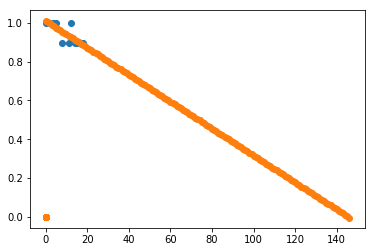

In [32]:
predict('DWD4F513604E44')

Note: We tried to use Tensorflow model at the beginning and here is the process, but apparently the results are not satisfactory, that's why we turn to Bayesian model.

LSTM Model:

In [29]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from os import path

import numpy as np
import tensorflow as tf

from tensorflow.contrib.timeseries.python.timeseries import estimators as ts_estimators
from tensorflow.contrib.timeseries.python.timeseries import model as ts_model
from tensorflow.contrib.timeseries.python.timeseries import  NumpyReader

import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt


class _LSTMModel(ts_model.SequentialTimeSeriesModel):
  """A time series model-building example using an RNNCell."""

  def __init__(self, num_units, num_features, dtype=tf.float32):
    """Initialize/configure the model object.
    Note that we do not start graph building here. Rather, this object is a
    configurable factory for TensorFlow graphs which are run by an Estimator.
    Args:
      num_units: The number of units in the model's LSTMCell.
      num_features: The dimensionality of the time series (features per
        timestep).
      dtype: The floating point data type to use.
    """
    super(_LSTMModel, self).__init__(
        # Pre-register the metrics we'll be outputting (just a mean here).
        train_output_names=["mean"],
        predict_output_names=["mean"],
        num_features=num_features,
        dtype=dtype)
    self._num_units = num_units
    # Filled in by initialize_graph()
    self._lstm_cell = None
    self._lstm_cell_run = None
    self._predict_from_lstm_output = None

  def initialize_graph(self, input_statistics):
    """Save templates for components, which can then be used repeatedly.
    This method is called every time a new graph is created. It's safe to start
    adding ops to the current default graph here, but the graph should be
    constructed from scratch.
    Args:
      input_statistics: A math_utils.InputStatistics object.
    """
    super(_LSTMModel, self).initialize_graph(input_statistics=input_statistics)
    self._lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=self._num_units)
    # Create templates so we don't have to worry about variable reuse.
    self._lstm_cell_run = tf.make_template(
        name_="lstm_cell",
        func_=self._lstm_cell,
        create_scope_now_=True)
    # Transforms LSTM output into mean predictions.
    self._predict_from_lstm_output = tf.make_template(
        name_="predict_from_lstm_output",
        func_=lambda inputs: tf.layers.dense(inputs=inputs, units=self.num_features),
        create_scope_now_=True)

  def get_start_state(self):
    """Return initial state for the time series model."""
    return (
        # Keeps track of the time associated with this state for error checking.
        tf.zeros([], dtype=tf.int64),
        # The previous observation or prediction.
        tf.zeros([self.num_features], dtype=self.dtype),
        # The state of the RNNCell (batch dimension removed since this parent
        # class will broadcast).
        [tf.squeeze(state_element, axis=0)
         for state_element
         in self._lstm_cell.zero_state(batch_size=1, dtype=self.dtype)])

  def _transform(self, data):
    """Normalize data based on input statistics to encourage stable training."""
    mean, variance = self._input_statistics.overall_feature_moments
    return (data - mean) / variance

  def _de_transform(self, data):
    """Transform data back to the input scale."""
    mean, variance = self._input_statistics.overall_feature_moments
    return data * variance + mean

  def _filtering_step(self, current_times, current_values, state, predictions):
    """Update model state based on observations.
    Note that we don't do much here aside from computing a loss. In this case
    it's easier to update the RNN state in _prediction_step, since that covers
    running the RNN both on observations (from this method) and our own
    predictions. This distinction can be important for probabilistic models,
    where repeatedly predicting without filtering should lead to low-confidence
    predictions.
    Args:
      current_times: A [batch size] integer Tensor.
      current_values: A [batch size, self.num_features] floating point Tensor
        with new observations.
      state: The model's state tuple.
      predictions: The output of the previous `_prediction_step`.
    Returns:
      A tuple of new state and a predictions dictionary updated to include a
      loss (note that we could also return other measures of goodness of fit,
      although only "loss" will be optimized).
    """
    state_from_time, prediction, lstm_state = state
    with tf.control_dependencies(
            [tf.assert_equal(current_times, state_from_time)]):
      transformed_values = self._transform(current_values)
      # Use mean squared error across features for the loss.
      predictions["loss"] = tf.reduce_mean(
          (prediction - transformed_values) ** 2, axis=-1)
      # Keep track of the new observation in model state. It won't be run
      # through the LSTM until the next _imputation_step.
      new_state_tuple = (current_times, transformed_values, lstm_state)
    return (new_state_tuple, predictions)

  def _prediction_step(self, current_times, state):
    """Advance the RNN state using a previous observation or prediction."""
    _, previous_observation_or_prediction, lstm_state = state
    lstm_output, new_lstm_state = self._lstm_cell_run(
        inputs=previous_observation_or_prediction, state=lstm_state)
    next_prediction = self._predict_from_lstm_output(lstm_output)
    new_state_tuple = (current_times, next_prediction, new_lstm_state)
    return new_state_tuple, {"mean": self._de_transform(next_prediction)}

  def _imputation_step(self, current_times, state):
    """Advance model state across a gap."""
    # Does not do anything special if we're jumping across a gap. More advanced
    # models, especially probabilistic ones, would want a special case that
    # depends on the gap size.
    return state

  def _exogenous_input_step(
          self, current_times, current_exogenous_regressors, state):
    """Update model state based on exogenous regressors."""
    raise NotImplementedError(
        "Exogenous inputs are not implemented for this example.")

/Users/BumbleBee/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/BumbleBee/anaconda3/envs/keras/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/BumbleBee/anaconda3/envs/keras/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/BumbleBee/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/BumbleBee/anaconda3/envs/keras/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/BumbleBee/ana

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c1d0197b8>, '_protocol': None, '_evaluation_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_task_id': 0, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_train_distribute': None, '_is_chief': True, '_device_fn': None, '_model_dir': '/var/folders/73/zpjp_wxj5jnch64_1fqqkx7h0000gn/T/tmp764h1qw_', '_master': '', '_experimental_distribute': None, '_service': None, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_eval_distribute': None, '_num_worker_replicas': 1, '_task_type': 'worker', '_global_id_in_cluster': 0}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for

INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).
INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).
INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /var/folders/73/zpjp_wxj5jnch64_1fqqkx7h0000gn/T/tmp764h1qw_/model.ckpt-2000
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tens

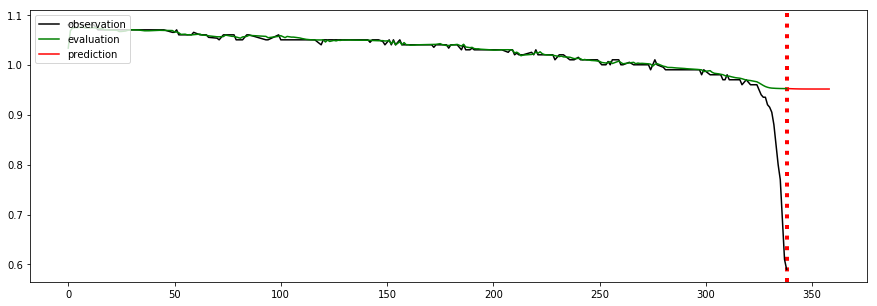

In [30]:
curve = battery('DWD4F513604E44')

#tf.logging.set_verbosity(tf.logging.INFO)
x = curve.use.values
y = curve.voltage.values

data = {
    tf.contrib.timeseries.TrainEvalFeatures.TIMES: x,
    tf.contrib.timeseries.TrainEvalFeatures.VALUES: y,
}

reader = NumpyReader(data)

train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(
    reader, batch_size=4, window_size=30)

estimator = ts_estimators.TimeSeriesRegressor(
    model=_LSTMModel(num_features=1, num_units=128),
    optimizer=tf.train.AdamOptimizer(0.001))

estimator.train(input_fn=train_input_fn, steps=2000)
evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
evaluation = estimator.evaluate(input_fn=evaluation_input_fn, steps=1)
# Predict starting after the evaluation
(predictions,) = tuple(estimator.predict(
     input_fn=tf.contrib.timeseries.predict_continuation_input_fn(
        evaluation, steps=20)))

observed_times = evaluation["times"][0]
observed = evaluation["observed"][0, :, :]
evaluated_times = evaluation["times"][0]
evaluated = evaluation["mean"][0]
predicted_times = predictions['times']
predicted = predictions["mean"]

plt.figure(figsize=(15, 5))
plt.axvline(curve.use.values.max(), linestyle="dotted", linewidth=4, color='r')
observed_lines = plt.plot(observed_times, observed, label="observation", color="k")
evaluated_lines = plt.plot(evaluated_times, evaluated, label="evaluation", color="g")
predicted_lines = plt.plot(predicted_times, predicted, label="prediction", color="r")
plt.legend(handles=[observed_lines[0], evaluated_lines[0], predicted_lines[0]],
            loc="upper left")
plt.savefig('predict_result.jpg')